# Value of a large ensemble for climate signal emergence figure

This should be a fairly simple instructive figure showing how large ensemble + long-PIC simulations aid climate signal emergence/detection/attribution.

Right now, I want three main panels with sub-panels below showing the probability of emergence. As we move to the right, the complexity of the method increases, as does the complexity of the simulations used.

_Panel 1: Assume a time-constant trend without uncertainty (Weatherhead and Leroy, maybe Tiao 1990). Detection is just a binary that occurs._

_Panel 2: Use a model to estimate a time-varying forced response without uncertainty (Feldman). Detection is still just a binary._

_Panel 3: Use a large ensemble to estimate a time-varying forced response with uncertainty (this work). Detection becomes a probability distribution._

I am going to use December sea ice data as an example because it has good non-linearities to make our points and I don't think sea ice in December has changed yet. OLR is surprisingly very linear, so it doesn't make as good of an example.

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Vectorize the numpy float function (not if something already does this)
npfloat_vec = np.vectorize(np.float)

### Load Data

#### Load pre-processed timeseries

In [3]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
# cesm1_forcedresponse_ds = xr.open_dataset('%s/CESM1_ForcedResponse_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)

#### Load pre-computed internal variability

In [4]:
# open lens variability characteristics (want OLR annual values)
ens_variability_filepath = '/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_vars.nc'

lens_variability_data = xr.open_dataset(ens_variability_filepath)

In [5]:
icefrac_annual_variability = lens_variability_data.sel(variable='ICEFRAC',month=12)

icefrac_annual_stddev = icefrac_annual_variability['stddev']
icefrac_annual_tauvar = icefrac_annual_variability['tauvar']

Calculate the uncertainty using the SNR method for the first two panels? Using the 1800-yr PIC simulation?

In [6]:
years = np.arange(1,81,1)
# print(years)
# calculate the uncertainty in a regress slope using noise estimated from PIC simulations
sigma_icefrac = (12*icefrac_annual_stddev.values**2*icefrac_annual_tauvar.values/years**3)**(1/2)

In [7]:
forced_response_2001_2050 = cesm1_ensresponse_ds['ICEFRAC'].mean(dim='ens') # 
forced_response_2001_2050_dec = forced_response_2001_2050.sel(time=forced_response_2001_2050['time.month']==12).groupby('time.year').mean(dim='time')

forced_response_2001_2015_dec = forced_response_2001_2050_dec.sel(year=slice(None,2015))

__Panel 1__

In [8]:
icefrac_dec2001_2015_polyfit = forced_response_2001_2015_dec.polyfit(dim='year',deg=1)
icefrac_dec2001_2015_slope   = icefrac_dec2001_2015_polyfit.sel(degree=1)['polyfit_coefficients']

In [9]:
persistence_guess = icefrac_dec2001_2015_slope.broadcast_like(forced_response_2001_2050_dec)

In [10]:
# Vectorize the numpy float function (not if something already does this)
npfloat_vec = np.vectorize(np.float)

detection_panel1_bool = np.abs(persistence_guess/sigma_icefrac) > 2
detection_panel1 = npfloat_vec(detection_panel1_bool)

__Panel 2__

In [11]:
# min_duration = 2
# max_duration = 80

# durations = np.arange(min_duration,max_duration+1)

# nmembers=40

# ens_tseries_ann = forced_response_2001_2050_dec # turn into annual tseries

# lens_slopes_dict = {}
# for _dur in durations: # iterate over possible detection durations 
#     tseries_dur_subset = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time

#     _lens_polyfit = tseries_dur_subset.polyfit(dim='year',deg=1) # take a linear fit
#     _lens_slopes = _lens_polyfit['polyfit_coefficients'].sel(degree=1).values # pull out the slope from the linear fit

#     lens_slopes_dict[_dur] = _lens_slopes # save slopes in an inner dictionary

# # shift the data to an xarray object so future operations do not require iteration
# seaice_forcedslopes_da = xr.DataArray(
#     data=np.stack(list(lens_slopes_dict.values()),axis=0),
#     dims=["duration"],
#     coords=dict(
#         duration=(durations),
#     ),
#     name = 'ICEFRAC'
# )
# # _temp_slopes_da = xr.DataArray(
# #     data=np.stack(list(lens_slopes_dict.values()),axis=1),
# #     dims=["ens", "duration"],
# #     coords=dict(
# #         ens=(np.arange(1,nmembers+1)),
# #         duration=(durations),
# #     ),
# #     name = 'ICEFRAC'
# # )

# del lens_slopes_dict                

In [12]:
# detection_panel2_bool = np.abs(seaice_forcedslopes_da/sigma_icefrac[1:]) > 2
# detection_panel2 = npfloat_vec(detection_panel2_bool)

In [13]:
# detection_panel2_bool = np.abs(seaice_slopes_da.sel(ens=24)/sigma_icefrac[1:]) > 2
# detection_panel2 = npfloat_vec(detection_panel2_bool)

__Panels 2 and 3__

In [14]:
min_duration = 2
max_duration = 80

durations = np.arange(min_duration,max_duration+1)

nmembers=40

ens_tseries_ann = cesm1_ensresponse_ds['ICEFRAC'].sel(time=forced_response_2001_2050['time.month']==12).groupby('time.year').mean(dim='time')

lens_slopes_dict = {}
for _dur in durations: # iterate over possible detection durations 
    tseries_dur_subset = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time

    _lens_polyfit = tseries_dur_subset.polyfit(dim='year',deg=1) # take a linear fit
    _lens_slopes = _lens_polyfit['polyfit_coefficients'].sel(degree=1).values # pull out the slope from the linear fit

    lens_slopes_dict[_dur] = _lens_slopes # save slopes in an inner dictionary

# shift the data to an xarray object so future operations do not require iteration
seaice_slopes_da = xr.DataArray(
    data=np.stack(list(lens_slopes_dict.values()),axis=1),
    dims=["ens", "duration"],
    coords=dict(
        ens=(np.arange(1,nmembers+1)),
        duration=(durations),
    ),
    name = 'ICEFRAC'
)

del lens_slopes_dict  

Pseudo-observations.

In [15]:
pseudo_obs_2001_2015 = xr.where(seaice_slopes_da['duration']<=15,
                                seaice_slopes_da.sel(ens=24),
                                seaice_slopes_da.sel(ens=24).sel(duration=15)
                               )

In [16]:
detection_pseudo_obs_bool = np.abs(pseudo_obs_2001_2015/sigma_icefrac[1:]) > 2
detection_pseudo_obs = npfloat_vec(detection_pseudo_obs_bool)

In [17]:
# forced_response_2001_2015_dec = forced_response_2001_2050_dec.sel(year=slice(None,2015))

# icefrac_dec2001_2015_polyfit = forced_response_2001_2015_dec.polyfit(dim='year',deg=1)
# icefrac_dec2001_2015_slope   = icefrac_dec2001_2015_polyfit.sel(degree=1)['polyfit_coefficients']

# persistence_guess = icefrac_dec2001_2015_slope.broadcast_like(forced_response_2001_2050_dec)

# # Vectorize the numpy float function (not if something already does this)
# npfloat_vec = np.vectorize(np.float)

# detection_panel1_bool = np.abs(persistence_guess/sigma_icefrac) > 2
# detection_panel1 = npfloat_vec(detection_panel1_bool)

In [18]:
detection_panel2_bool = np.abs(seaice_slopes_da.sel(ens=24)/sigma_icefrac[1:]) > 2
detection_panel2 = npfloat_vec(detection_panel2_bool)

In [19]:
# Calculate booleans for climate signal emergence (but if an ensemble member returns to internal variability, this is wrong!)
detection_panel3_bool = np.abs(seaice_slopes_da/sigma_icefrac[1:]) > 2
# detection_panel3 = npfloat_vec(detection_panel3_bool).sum(axis=0) / 40

# Apply our definition of emergence where the signal must remain out of the internal variability
duration = seaice_slopes_da['duration']

emergence_year = 1 + duration.where(~detection_panel3_bool).max(dim='duration')
emergence_year_broad =  emergence_year.broadcast_like(detection_panel3_bool)

detection_panel3_bool_corrected = detection_panel3_bool.where(detection_panel3_bool.duration > emergence_year_broad,0)
detection_panel3_corrected = npfloat_vec(detection_panel3_bool_corrected).sum(axis=0) / 40

Using the bootstrapping approach to smooth the 40-member ensemble.

In [20]:
def bootstrap_percentiles2(varname,slope_ds,durations,alpha,nbootstraps=2000):
    '''
    Function to bootstrap 5th and 95th percentiles AND the mean(!!) on slopes for different durations,
    and return the result in an xarray format.
    Assumes that it will be passed a xr.dataset object and list of durations.
    '''
    
    _bounds_dict_bstrap_dur = {} # empty dictionary to store objects in
        
    for _dur in durations:
        # select slopes for a given duration and variable, drop nans
        _slopes     = slope_ds[varname].sel(duration=_dur).dropna(dim='ens') 
        N_ens       = len(_slopes) # number of members

        # Compute percentiles using bootstrapping
        lower_percentile = []
        upper_percentile = []
        mean_slope = []
        
        for i in range(1,nbootstraps): # bootstrap, calculating percentiles
            resample_slopes = np.random.choice(_slopes, N_ens, replace=True) # resample with replacement
            lower_percentile.append(np.percentile(resample_slopes,100*(alpha/2)))
            upper_percentile.append(np.percentile(resample_slopes,100*(1-alpha/2)))
            mean_slope.append(np.mean(resample_slopes))
        
        _lower_bnd_bstrap    = np.mean(lower_percentile) # take the mean percentile
        _upper_bnd_bstrap    = np.mean(upper_percentile)
        _mean_slope_bstrap = np.mean(mean_slope)
        
        _bounds_dict_bstrap_dur[_dur] = [_lower_bnd_bstrap,_upper_bnd_bstrap,_mean_slope_bstrap] # save in the dictionary
                
    # save output in an xarray format for easy future usage
    _bounds_da = xr.DataArray(
        data=np.stack(list(_bounds_dict_bstrap_dur.values()),axis=1),
        dims=["bound", "duration"],
        coords=dict(
            bound=[0,1,2], # 0 is the lower bound (5th perc.) and 1 is the upper bound (95th perc.)
            duration=(durations),
        ),
        name = varname
    )
    
    del _bounds_dict_bstrap_dur # clean up
    
    return _bounds_da

Takes about 2 minutes.

In [21]:
%%time

CI_seaice_dec = bootstrap_percentiles2('ICEFRAC',seaice_slopes_da.to_dataset(),durations,alpha=0.05,nbootstraps=5000)

CPU times: user 1min 45s, sys: 0 ns, total: 1min 45s
Wall time: 1min 49s


In [22]:
detect_panel3_CI_lower_bool = np.abs(CI_seaice_dec.sel(bound=0)/sigma_icefrac[1:]) > 2
detect_panel3_CI_upper_bool = np.abs(CI_seaice_dec.sel(bound=1)/sigma_icefrac[1:]) > 2

In [23]:
# Apply our definition of emergence where the signal must remain out of the internal variability
duration = CI_seaice_dec['duration']

emergence_year_lower = 1 + duration.where(~detect_panel3_CI_lower_bool).max(dim='duration')

# detection_panel3_lower_bool = detect_panel3_CI_lower_bool.where(detect_panel3_CI_lower_bool.duration > emergence_year_lower,0)
# detection_panel3_lower = npfloat_vec(detection_panel3_lower_bool)

emergence_year_upper = 1 + duration.where(~detect_panel3_CI_upper_bool).max(dim='duration')

# detection_panel3_upper_bool = detect_panel3_CI_upper_bool.where(detect_panel3_CI_upper_bool.duration > emergence_year_upper,0)
# detection_panel3_upper = npfloat_vec(detection_panel3_upper_bool)

Create the figure with axes using gridspec.

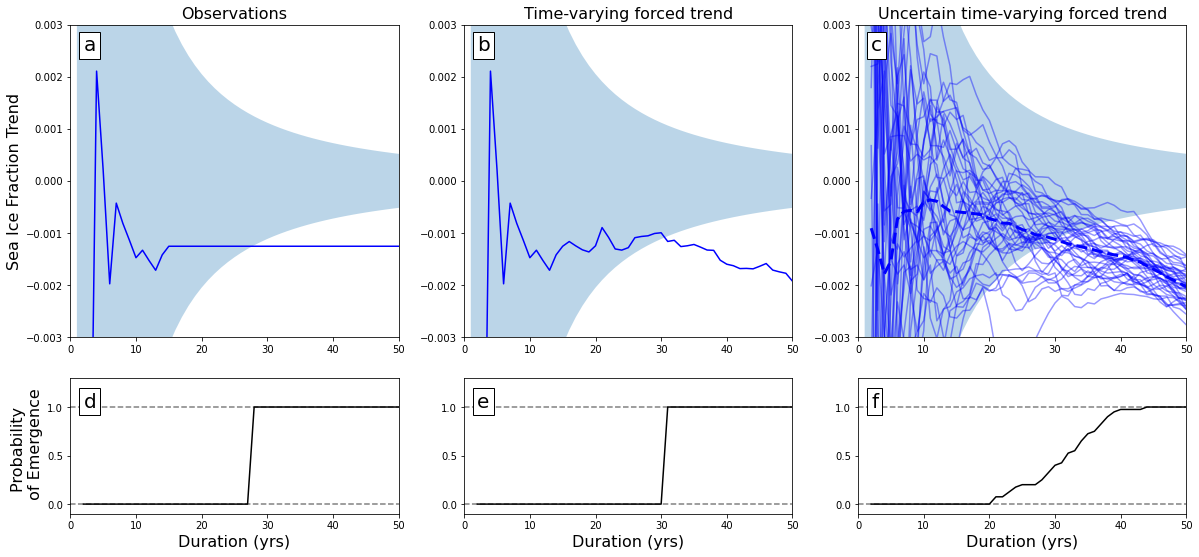

In [30]:
fig = plt.figure(constrained_layout=False,figsize=(20,9))

gs = gridspec.GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])
ax3 = fig.add_subplot(gs[:2, 2])

ax4 = fig.add_subplot(gs[-1, 0])
ax5 = fig.add_subplot(gs[-1, 1])
ax6 = fig.add_subplot(gs[-1, 2])

# ax1.set_ylabel('OLR Trend (Wm$^{-2}$)',fontsize=16)
ax1.set_ylabel('Sea Ice Fraction Trend',fontsize=16)
ax4.set_ylabel('Probability \n of Emergence',fontsize=16)

for _ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    _ax.set_xlim(0,50)
    
for _low_ax in [ax4,ax5,ax6]:
    _low_ax.set_xlabel('Duration (yrs)',fontsize=16)
    _low_ax.set_ylim(-0.10,1.3)
    _low_ax.set_yticks([0,0.5,1.0])
    _low_ax.hlines(y=[0,1],xmin=0,xmax=50,linestyles='dashed',colors='black',alpha=0.5)

ax1.set_title('Observations',fontsize=16)
# ax1.set_title('Constant forced trend',fontsize=16)
ax2.set_title('Time-varying forced trend',fontsize=16)
ax3.set_title('Uncertain time-varying forced trend',fontsize=16)

#### First column
ax1.fill_between(years,-2*sigma_icefrac,2*sigma_icefrac,alpha=0.3)
ax1.plot(years[1:],pseudo_obs_2001_2015,color='blue',alpha=1)
# ax1.plot(years,persistence_guess,color='blue',alpha=1)
ax1.set_ylim(-0.003,0.003)

detection_pseudo_obs
ax4.plot(years[1:],detection_pseudo_obs,color='black',alpha=1)
# ax4.plot(years,detection_panel1,color='black',alpha=1)

#### Second column
ax2.fill_between(years,-2*sigma_icefrac,2*sigma_icefrac,alpha=0.3)
# ax2.plot(years[1:],seaice_forcedslopes_da)
ax2.plot(years[1:],seaice_slopes_da.sel(ens=24),color='blue',alpha=1)
ax2.set_ylim(-0.003,0.003)
ax5.plot(years[1:],detection_panel2,color='black',alpha=1)

#### Third column
ax3.fill_between(years,-2*sigma_icefrac,2*sigma_icefrac,alpha=0.3)
forcedresponse_seaice_slopes = seaice_slopes_da.mean(dim='ens')

for _ens_seaice_slopes in seaice_slopes_da:
    ax3.plot(years[1:],_ens_seaice_slopes,color='blue',alpha=0.4)
ax3.plot(years[1:],forcedresponse_seaice_slopes,color='blue',alpha=1,linestyle='dashed',linewidth=3)
# ax3.plot(years[1:],seaice_slopes_da.sel(ens=24),color='blue',alpha=1)

ax3.set_ylim(-0.003,0.003)
ax6.plot(years[1:],detection_panel3_corrected,color='black',alpha=1)

# these are matplotlib.patch.Patch properties
props = dict(facecolor='white', alpha=1)
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax1.text(2,0.0025,'a',fontsize=20,bbox=props)
ax2.text(2,0.0025,'b',fontsize=20,bbox=props)
ax3.text(2,0.0025,'c',fontsize=20,bbox=props)

ax4.text(2,1,'d',fontsize=20,bbox=props)
ax5.text(2,1,'e',fontsize=20,bbox=props)
ax6.text(2,1,'f',fontsize=20,bbox=props)

# fig.suptitle("Emergence of Climate Signals")
fig.subplots_adjust(hspace=0.3)

In [31]:
to_png(fig,'methodsfig_LENSdetect3',bbox_inches='tight',ext='pdf')

### Original version code

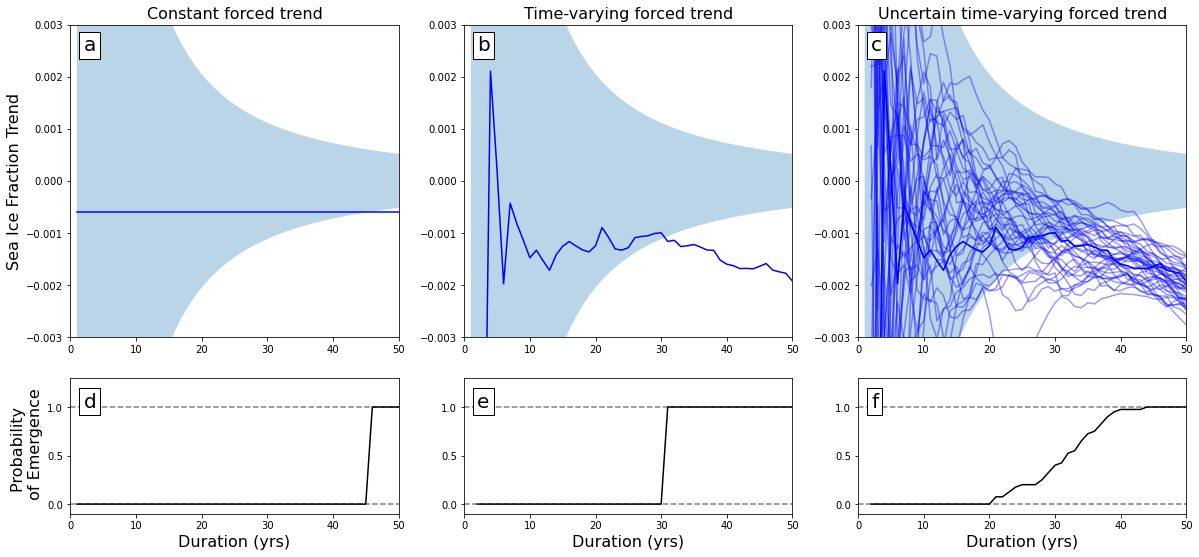

In [26]:
fig = plt.figure(constrained_layout=False,figsize=(20,9))

gs = gridspec.GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])
ax3 = fig.add_subplot(gs[:2, 2])

ax4 = fig.add_subplot(gs[-1, 0])
ax5 = fig.add_subplot(gs[-1, 1])
ax6 = fig.add_subplot(gs[-1, 2])

# ax1.set_ylabel('OLR Trend (Wm$^{-2}$)',fontsize=16)
ax1.set_ylabel('Sea Ice Fraction Trend',fontsize=16)
ax4.set_ylabel('Probability \n of Emergence',fontsize=16)

for _ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    _ax.set_xlim(0,50)
    
for _low_ax in [ax4,ax5,ax6]:
    _low_ax.set_xlabel('Duration (yrs)',fontsize=16)
    _low_ax.set_ylim(-0.10,1.3)
    _low_ax.set_yticks([0,0.5,1.0])
    _low_ax.hlines(y=[0,1],xmin=0,xmax=50,linestyles='dashed',colors='black',alpha=0.5)

ax1.set_title('Constant forced trend',fontsize=16)
ax2.set_title('Time-varying forced trend',fontsize=16)
ax3.set_title('Uncertain time-varying forced trend',fontsize=16)

#### First column
ax1.fill_between(years,-2*sigma_icefrac,2*sigma_icefrac,alpha=0.3)
ax1.plot(years,persistence_guess,color='blue',alpha=1)
ax1.set_ylim(-0.003,0.003)

ax4.plot(years,detection_panel1,color='black',alpha=1)

#### Second column
ax2.fill_between(years,-2*sigma_icefrac,2*sigma_icefrac,alpha=0.3)
# ax2.plot(years[1:],seaice_forcedslopes_da)
ax2.plot(years[1:],seaice_slopes_da.sel(ens=24),color='blue',alpha=1)
ax2.set_ylim(-0.003,0.003)
ax5.plot(years[1:],detection_panel2,color='black',alpha=1)

#### Third column
ax3.fill_between(years,-2*sigma_icefrac,2*sigma_icefrac,alpha=0.3)
for _ens_seaice_slopes in seaice_slopes_da:
    ax3.plot(years[1:],_ens_seaice_slopes,color='blue',alpha=0.4)
ax3.plot(years[1:],seaice_slopes_da.sel(ens=24),color='blue',alpha=1)

ax3.set_ylim(-0.003,0.003)
ax6.plot(years[1:],detection_panel3_corrected,color='black',alpha=1)

# these are matplotlib.patch.Patch properties
props = dict(facecolor='white', alpha=1)
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax1.text(2,0.0025,'a',fontsize=20,bbox=props)
ax2.text(2,0.0025,'b',fontsize=20,bbox=props)
ax3.text(2,0.0025,'c',fontsize=20,bbox=props)

ax4.text(2,1,'d',fontsize=20,bbox=props)
ax5.text(2,1,'e',fontsize=20,bbox=props)
ax6.text(2,1,'f',fontsize=20,bbox=props)

# fig.suptitle("Emergence of Climate Signals")
fig.subplots_adjust(hspace=0.3)

In [27]:
# to_png(fig,'methodsfig_LENSdetect1',bbox_inches='tight')

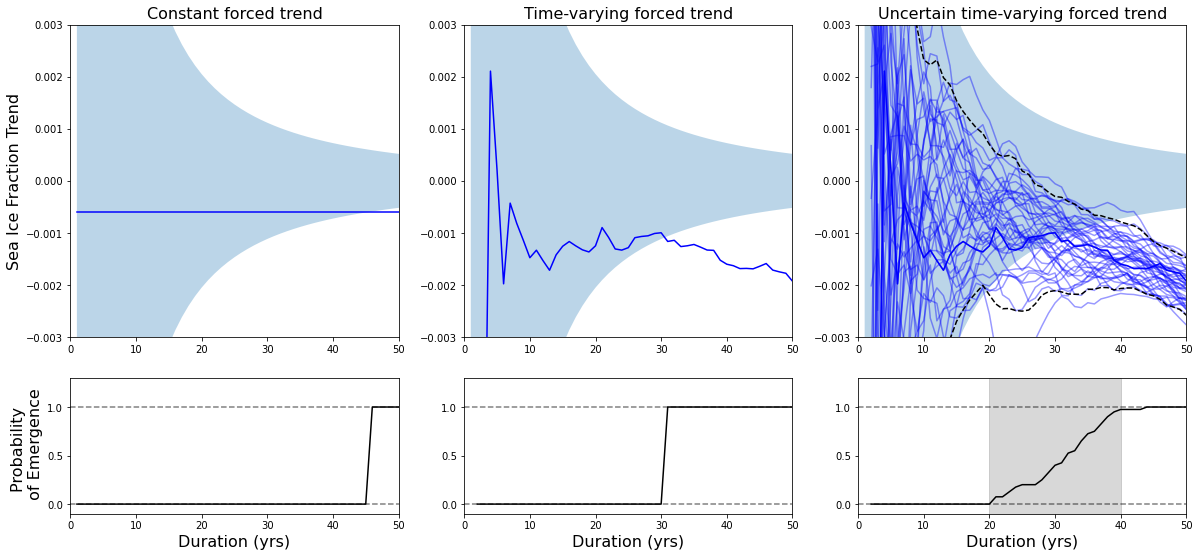

In [28]:
fig = plt.figure(constrained_layout=False,figsize=(20,9))

gs = gridspec.GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])
ax3 = fig.add_subplot(gs[:2, 2])

ax4 = fig.add_subplot(gs[-1, 0])
ax5 = fig.add_subplot(gs[-1, 1])
ax6 = fig.add_subplot(gs[-1, 2])

# ax1.set_ylabel('OLR Trend (Wm$^{-2}$)',fontsize=16)
ax1.set_ylabel('Sea Ice Fraction Trend',fontsize=16)
ax4.set_ylabel('Probability \n of Emergence',fontsize=16)

for _ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    _ax.set_xlim(0,50)
    
for _low_ax in [ax4,ax5,ax6]:
    _low_ax.set_xlabel('Duration (yrs)',fontsize=16)
    _low_ax.set_ylim(-0.10,1.3)
    _low_ax.set_yticks([0,0.5,1.0])
    _low_ax.hlines(y=[0,1],xmin=0,xmax=50,linestyles='dashed',colors='black',alpha=0.5)

ax1.set_title('Constant forced trend',fontsize=16)
ax2.set_title('Time-varying forced trend',fontsize=16)
ax3.set_title('Uncertain time-varying forced trend',fontsize=16)

#### First column
ax1.fill_between(years,-2*sigma_icefrac,2*sigma_icefrac,alpha=0.3)
ax1.plot(years,persistence_guess,color='blue',alpha=1)
ax1.set_ylim(-0.003,0.003)

ax4.plot(years,detection_panel1,color='black',alpha=1)

#### Second column
ax2.fill_between(years,-2*sigma_icefrac,2*sigma_icefrac,alpha=0.3)
# ax2.plot(years[1:],seaice_forcedslopes_da)
ax2.plot(years[1:],seaice_slopes_da.sel(ens=24),color='blue',alpha=1)
ax2.set_ylim(-0.003,0.003)
ax5.plot(years[1:],detection_panel2,color='black',alpha=1)

#### Third column
ax3.fill_between(years,-2*sigma_icefrac,2*sigma_icefrac,alpha=0.3)
for _ens_seaice_slopes in seaice_slopes_da:
    ax3.plot(years[1:],_ens_seaice_slopes,color='blue',alpha=0.4)
ax3.plot(years[1:],seaice_slopes_da.sel(ens=24),color='blue',alpha=1)

ax3.set_ylim(-0.003,0.003)
ax6.plot(years[1:],detection_panel3_corrected,color='black',alpha=1)

ax3.plot(CI_seaice_dec.duration,CI_seaice_dec.sel(bound=0),color='black',linestyle='dashed')
ax3.plot(CI_seaice_dec.duration,CI_seaice_dec.sel(bound=1),color='black',linestyle='dashed')
# ax3.plot(CI_seaice_dec.duration,CI_seaice_dec.sel(bound=2))

ax6.axvspan(xmin=emergence_year_lower, xmax=emergence_year_upper, color='grey', alpha=0.3)
# ax6.fill_between(emergence_year_lower,emergence_year_upper

# fig.suptitle("Emergence of Climate Signals")
fig.subplots_adjust(hspace=0.3)

The bootstrapping doesn't add value here, so I'll stick with the simpler and clearer version.

In [29]:
# to_png(fig,'methodsfig_LENSdetect2')